In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize 

import warnings
warnings.filterwarnings("ignore")

# Import own libraries 
import os, sys
script_path = os.path.realpath(os.path.dirname("10_on_trajectories"))
os.chdir(script_path)
sys.path.append("..")

from myLibraries.queries import * 
from myLibraries.events import *
from myLibraries.theoretical_functions import *

In [2]:
HOLE_SIZE = 28

EVENTS = get_collabs_event()
ALL_EVENTS = get_allEvents(EVENTS)

YEARS = get_str_years_event()

# get rid of misleading years
YEARS_TO_CONSIDER = YEARS[11: -8]
EVENTS_TO_CONSIDER = YEARS[11: -8]

# **Logarithmic Trajectories (consdering only 10 years)**

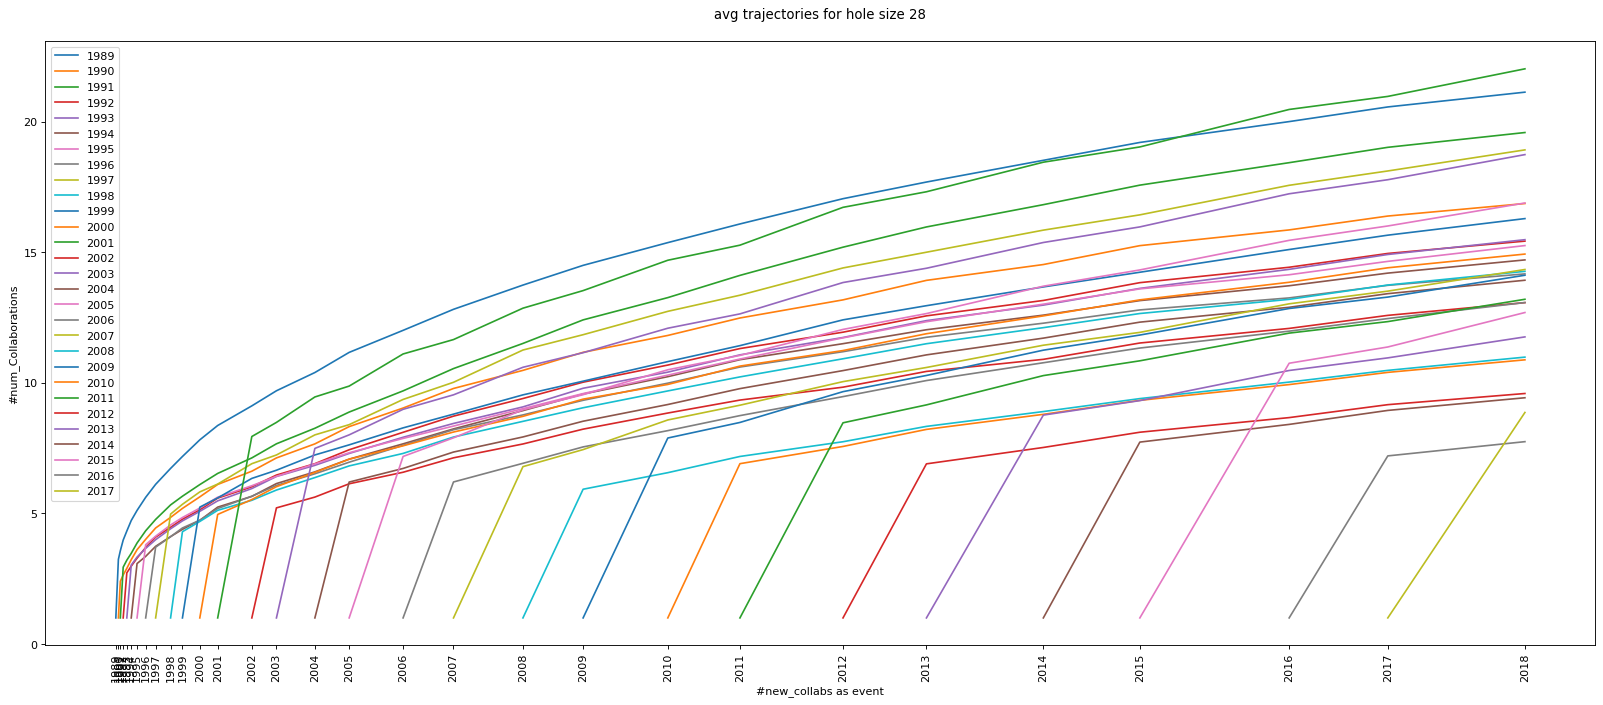

In [3]:
## Plot average trajectories 
plt.figure(figsize=(25, 10), dpi=80)
plt.title("avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

for start_y in YEARS[:-1]:
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    
    if(len(y)==1):
        plt.scatter(x,y)
    else:
        plt.plot(x,y)
    
    plt.xticks(x, y)
    plt.xticks(rotation='vertical')
    
plt.legend(YEARS, loc='upper left')
plt.xticks(EVENTS, YEARS)
plt.show()

# **(2) Plotting fitting function**

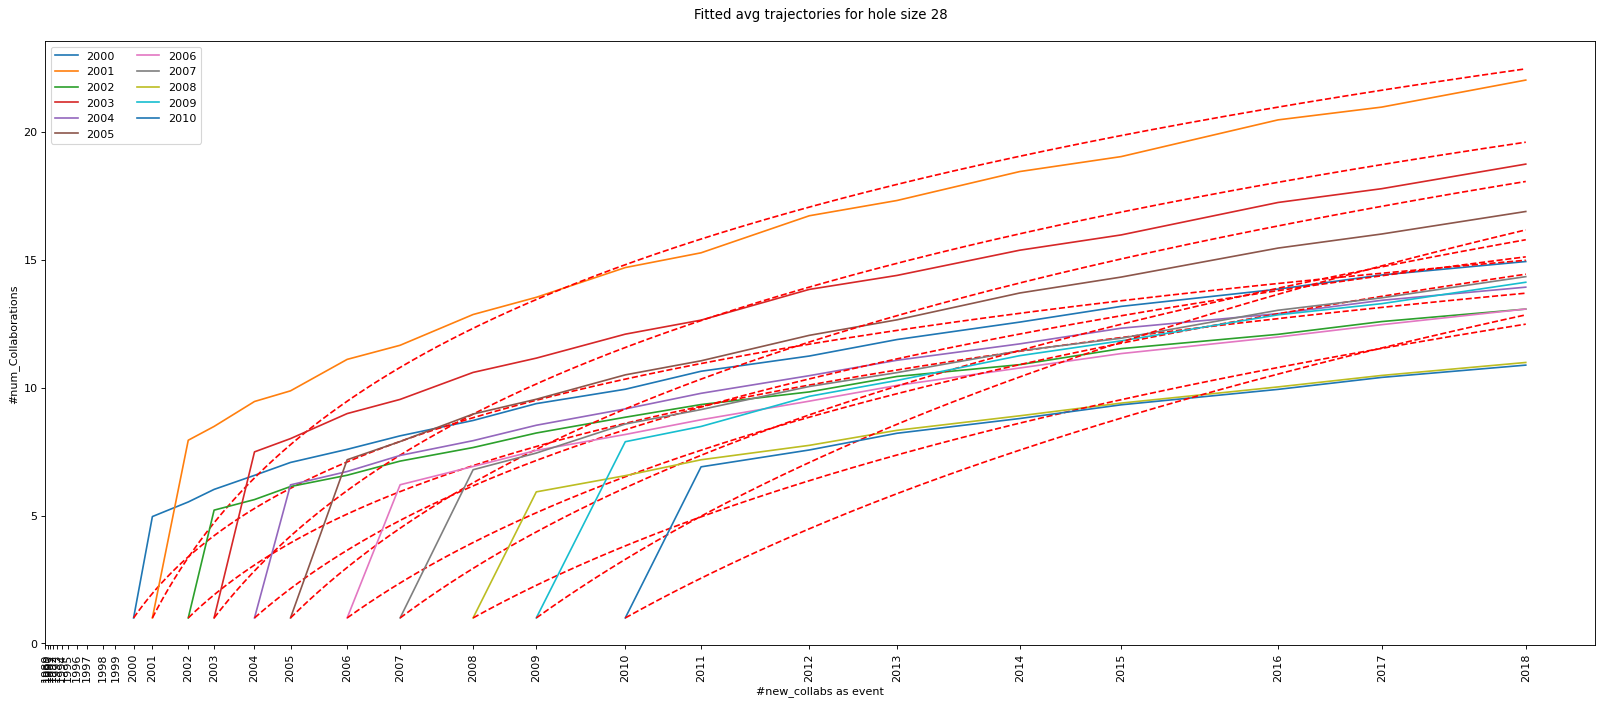

In [3]:
## Plot fitted average trajectories
plt.figure(figsize=(25, 10), dpi=80)
plt.title("Fitted avg trajectories for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

alphas = []
betas = []
for start_y in YEARS_TO_CONSIDER:
    
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size)     
    fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
    
    xdata = [a for a in range(x[0], x[-1])]
    fit_y = theoretical_func(xdata, alpha, beta, x[0])

    # save fitted parameters alpha, beta
    alphas.append(alpha)
    betas.append(beta)
    
    plt.plot(x,y, label=str(start_y))
    plt.plot(xdata, fit_y, 'r--')

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=2)
plt.xticks(EVENTS, YEARS)
plt.show()

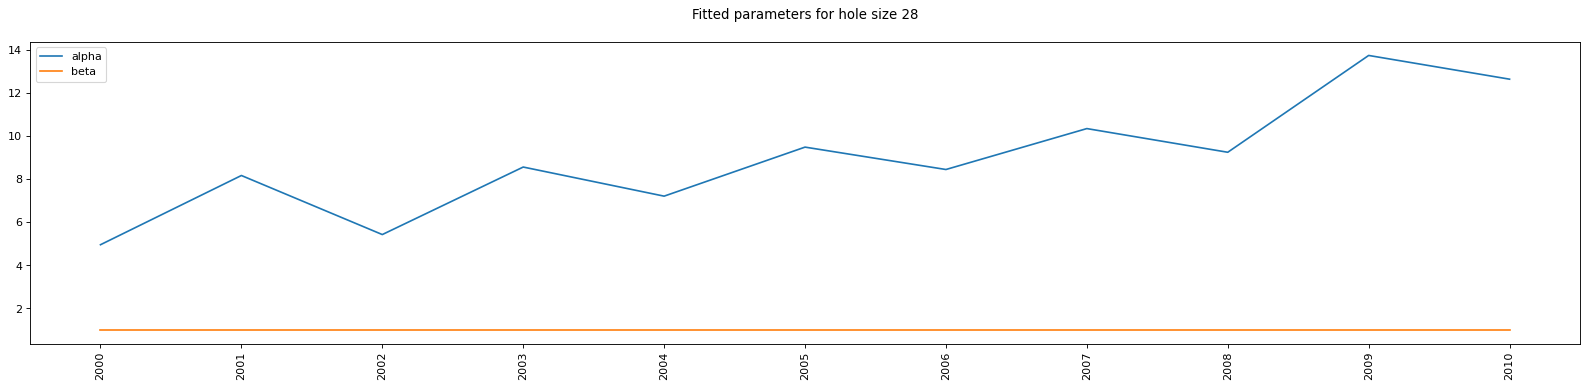

   start_y      alpha  beta
0     2000   4.957643   1.0
1     2001   8.170479   1.0
2     2002   5.429496   1.0
3     2003   8.563082   1.0
4     2004   7.212045   1.0
5     2005   9.487764   1.0
6     2006   8.448776   1.0
7     2007  10.348011   1.0
8     2008   9.249046   1.0
9     2009  13.742495   1.0
10    2010  12.640909   1.0


In [4]:
## Plotting and Printing fitted parameters alpha and beta for each starting year
plt.figure(figsize=(25, 5), dpi=80)
plt.title("Fitted parameters for hole size " + str(HOLE_SIZE) + "\n", fontdict = {'fontsize' : 12})


plt.plot(EVENTS_TO_CONSIDER, alphas, label="alpha")
plt.plot(EVENTS_TO_CONSIDER, betas, label="beta")

plt.xticks(EVENTS_TO_CONSIDER, YEARS_TO_CONSIDER)
plt.xticks(rotation='vertical')
plt.legend()
plt.show()

print(pd.DataFrame([[YEARS_TO_CONSIDER[i], alphas[i], betas[i]] for i in range(len(alphas))], columns=["start_y", "alpha", "beta"]))

# **(3)** Find **alpha\* and beta\*** to have a function **f\*** minimizing the **errors**

given a starting event $i$:
- Let $e$ be a generic event
- Let $r_i(e)$ be the function representing the real average trajectory for authors who started to publish at the event $i$
- Let $f_i(e)$ be the fitted function of $r_i(e)$
- Let $f_i^*(e)$ be the general fitting function of which we want to optimized the parameters, for authors who started to publish at the event $i$

#### A) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$
#### B) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - r_i(e) |^2 \Biggr)$ 

#### C) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \sum_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 
#### D) $min_{\alpha^*,\sigma^*} \Biggl( \sum_i \max_{e\geq i} |f_i^* (e) - f_i(e) |^2 \Biggr)$ 

In [6]:
##### ERRORS FUNCTIONS FOR AVERAGE TRAJECTORIES #####

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_A(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
            err += pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2)

    sys.stdout.write('\r'+ "optimizing A function with -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with real data 
def err_f_B(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        
        tmp = []
        for curr_y in YEARS[i:][:-1]:
            e = YEARS.index(curr_y)
        
            tmp.append(pow(abs(theoretical_func(xdata[e], opt_alpha, opt_beta, xdata[i]) - y[YEARS[i:][:-1].index(curr_y)]), 2))
        err += np.max(tmp)
    
    sys.stdout.write('\r'+ "optimizing B function with -> params: " + str(params) +", error: "+ str(err))
    return err

SUBSET_SIZE = 200 # the next error function works on all events, choose the number of event to be considered 

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_C(params, xdata, hole_size, years_to_consider=YEARS):
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
        
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)    
        curr_x = xdata[i]  
        
        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 
        

        for e in events_subset:
            if(e>curr_x):
                err += pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2)

    sys.stdout.write('\r'+ "optimizing C function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

## error function to minimize in order to find alpha* and beta*
    ## this function compare f* with fitted data f_i 
        ## we consider a subset of events for computational costs
def err_f_D(params, xdata, hole_size, years_to_consider=YEARS):
    
    opt_alpha, opt_beta = params
    
    size = SUBSET_SIZE # subset of events to consider 
    
    all_events = [e for e in range(xdata[-1])]
    next_events = all_events
    n = (len(next_events))//size
        
    events_subset = [next_events[e] for e in range(len(next_events)) if e%n==0][:size]
    
    err = 0
    for start_y in years_to_consider:
        i = YEARS.index(start_y)
        
        curr_x = xdata[i]  

        x,y = get_avg_trajectories(xdata, hole_size, start_y)
        fit_y, alpha, beta = fit_trajectory(x, y) # fit the real data above with the theoretical trajectory 

        tmp = []
        for e in events_subset:
            if(e>curr_x):
                tmp.append(pow(abs(theoretical_func(e, opt_alpha, opt_beta, xdata[i]) - theoretical_func(e, alpha, beta, xdata[i])), 2))
             
        if((len(tmp))!=0):
            err += np.max(tmp)
        
    sys.stdout.write('\r'+ "optimizing D function with " + str(size) + " events -> params: " + str(params) +", error: "+ str(err))
    return err

In [7]:
## optimize alpha* and beta* for each error function defined above 
alphas_opt,betas_opt, errs = [],[],[]

start_params = [1, 1]
bnds = ((0, None), (1, None))

# retrieve alpha* and beta* minimizing the associated function and
    # compute the error made by the optimized parameters 

result_A = minimize(err_f_A, start_params, args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_A = result_A.x
alphas_opt.append(fitted_params_A[0])
betas_opt.append(fitted_params_A[1])
errs.append(err_f_A(fitted_params_A, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_B = minimize(err_f_B, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_B = result_B.x
alphas_opt.append(fitted_params_B[0])
betas_opt.append(fitted_params_B[1])
errs.append(err_f_B(fitted_params_B, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()


result_C = minimize(err_f_C, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_C = result_C.x
alphas_opt.append(fitted_params_C[0])
betas_opt.append(fitted_params_C[1])
errs.append(err_f_C(fitted_params_C, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

result_D = minimize(err_f_D, [1, 1], args=(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER), bounds=bnds)
fitted_params_D = result_D.x
alphas_opt.append(fitted_params_D[0])
betas_opt.append(fitted_params_D[1])
errs.append(err_f_D(fitted_params_D, EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER))
print()

print()
print(pd.DataFrame([[errs[i], alphas_opt[i], betas_opt[i]] for i in range(len(errs))], ["err_f_A", "err_f_B", "err_f_C", "err_f_D"], ["ERROR", "alpha", "beta",]))

optimizing A function with -> params: [7.35869311 1.        ], error: 1393.8852547710603
optimizing B function with -> params: [6.57711926 1.        ], error: 235.30842574963333
optimizing C function with 200 events -> params: [7.37424529 1.        ], error: 14834.989920728214
optimizing D function with 200 events -> params: [7.65731326 1.        ], error: 188.368232441037526

                ERROR     alpha  beta
err_f_A   1393.885255  7.358693   1.0
err_f_B    235.308426  6.577119   1.0
err_f_C  14834.989921  7.374245   1.0
err_f_D    188.368232  7.657313   1.0


In [5]:
alphas_opt,betas_opt, errs = [7.358693, 6.577119, 7.374245, 7.657313], [1, 1, 1, 1], [1393.885255, 235.308426, 14834.989921, 188.368232]

# **(4) Shift fitted trajectories, compute their average and fit it**

In [8]:
# Shift all fitted trajectories
shifted_funcs = []

i = 0
for i in range(len(alphas)):
    
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, YEARS_TO_CONSIDER[i])

    xdata = [e+x[0] for e in ALL_EVENTS]        
    f = theoretical_func(xdata, alphas[i], betas[i], x[0])
    
    shifted_funcs.append(f) # add function to the set
    i+=1

In [9]:
# compute the average of the shifted functions and fit the average curve
avg_shift = np.average(np.array(shifted_funcs), axis=0)
fit_avg_shift , alpha, beta = fit_trajectory(ALL_EVENTS, avg_shift) 

print("The fitted parameters are:")
print(" alpha*:", alpha, "\n beta*:", beta)

The fitted parameters are:
 alpha*: 5.159505970273009e-05 
 beta*: 3490.1281723574884


In [6]:
alpha, beta = 5.159505970273009e-05 , 3490.1281723574884
fit_avg_shift = theoretical_func(ALL_EVENTS, alpha, beta, np.int64(1))

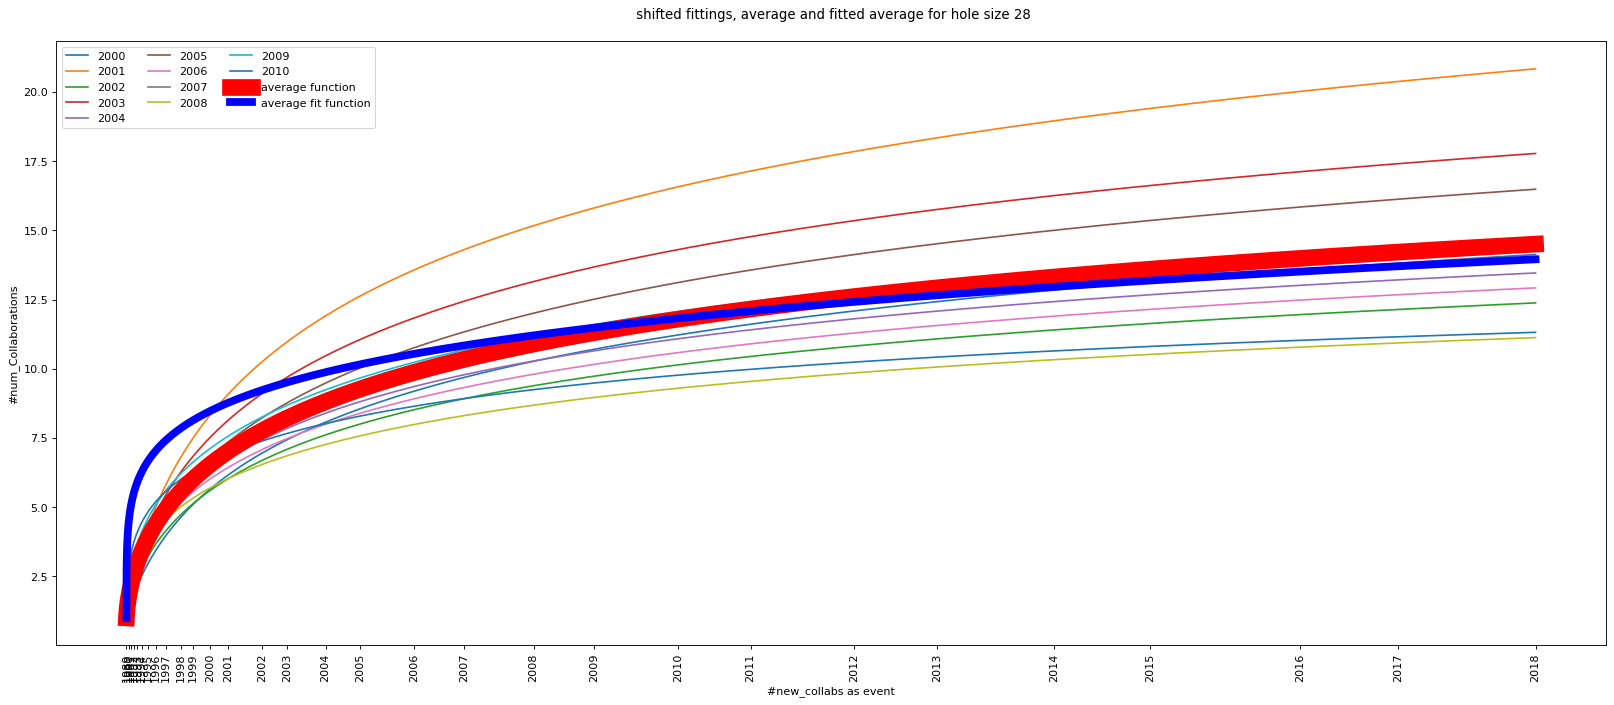

In [9]:
# plot shifted fittings, their average and it's fitting
plt.figure(figsize=(25, 10), dpi=80)
plt.title(" shifted fittings, average and fitted average for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
plt.xlabel("#new_collabs as event")
plt.ylabel("#num_Collaborations")
plt.xticks(rotation='vertical')

j = 0
for start_y in YEARS_TO_CONSIDER:
    plt.plot(ALL_EVENTS,shifted_funcs[j], label=start_y)
    j = j+1    
    
    
plt.plot(ALL_EVENTS, avg_shift, 'r-+', label="average function",  linewidth=15.0)
plt.plot(ALL_EVENTS, fit_avg_shift, 'b-', label="average fit function", linewidth=7.0)

plt.xticks(rotation='vertical')    
plt.legend(loc='upper left', ncol=3)
plt.xticks(EVENTS, YEARS)
plt.show()

# **(5) compare general fitting error functions A,B,C and D with the general average fitted one**  

### Error fitted trajectories

In [9]:
## get general fitting functions by starting year for each couple of parameter found above 
error_f_labels = ["A", "B", "C", "D"] 
error_fit_functions = {}

for i in range(len(error_f_labels)):
    # get general error fitted functions by starting year
    functions_by_start_y = [] # contains fitted error functions for each year 
    for start_y in YEARS_TO_CONSIDER:
        curr_x = EVENTS[YEARS.index(start_y)]  
        x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
        
        xdata = [e for e in range(x[0], x[-1])] # xdata is the list of events
        general_fit_y = theoretical_func(xdata, alphas_opt[i], betas_opt[i], curr_x)
        functions_by_start_y.append(general_fit_y)

    error_fit_functions[error_f_labels[i]] = functions_by_start_y

### Average fitted trajectories

In [10]:
## get general fitting functions for each starting year for alpha* and beta* of the fitted average
average_fit_functions = [] # contains fitted error functions for each year 
for start_y in YEARS_TO_CONSIDER:

    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y) # retrieve average trajecory for the given start_y (and hole size) 
    xdata = [e-x[0] for e in range(x[0],x[-1])]
    
    general_fit_y = theoretical_func(xdata, alpha, beta, np.int64(1))
    average_fit_functions.append(general_fit_y)

### **plot everything**

In [19]:
# plot all the fitted functions for each starting year for each couple of parameters
def plot_all(start_y):
    # given the start_y to consider it plots the real curver, the error fitted one and the average fitted toghether 
    plt.figure(figsize=(25, 10), dpi=80)
    plt.title("compare general fitting error functions with the general average fitted one for the starting year " + start_y + " for hole size "+ str(HOLE_SIZE) +  "\n", fontdict = {'fontsize' : 12})
    plt.xlabel("#new_collabs as event")
    plt.ylabel("#num_Collaborations")
    plt.xticks(rotation='vertical')

    j = YEARS_TO_CONSIDER.index(start_y)
    x,y = get_avg_trajectories(EVENTS, HOLE_SIZE, start_y)
    plt.plot(x,y, label="real data")

    xdata = [e for e in range(x[0],x[-1])]

    for i in range(len(error_f_labels)):
        err_f = error_fit_functions[error_f_labels[i]][j]
        plt.plot(xdata, err_f, label="error fit function "+ error_f_labels[i])

    plt.plot(xdata, average_fit_functions[j], label="average fit function")

    plt.xticks(rotation='vertical')    
    plt.legend(loc='upper left')    
    plt.xticks(x, YEARS[YEARS.index(start_y):])
    plt.show()

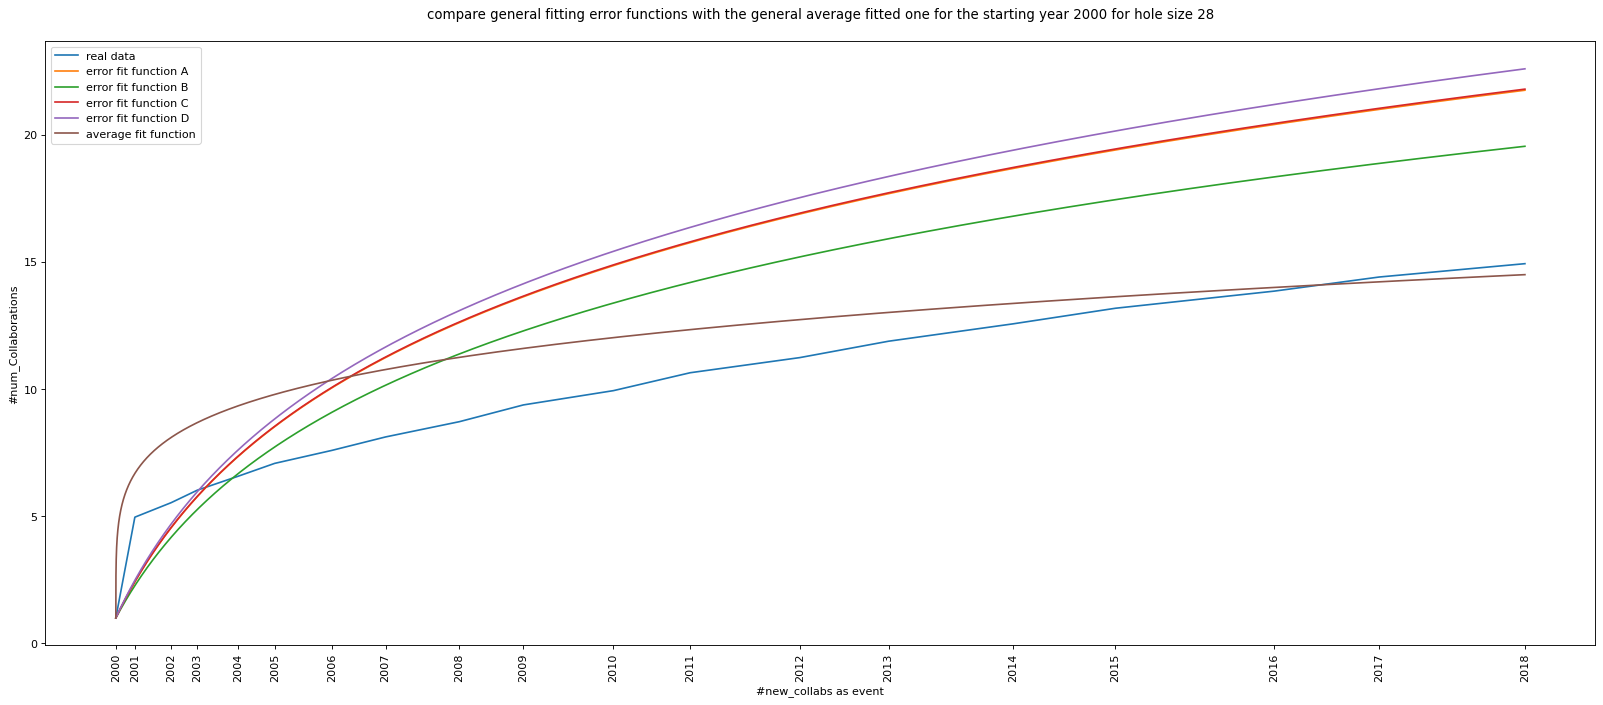

In [20]:
plot_all("2000")

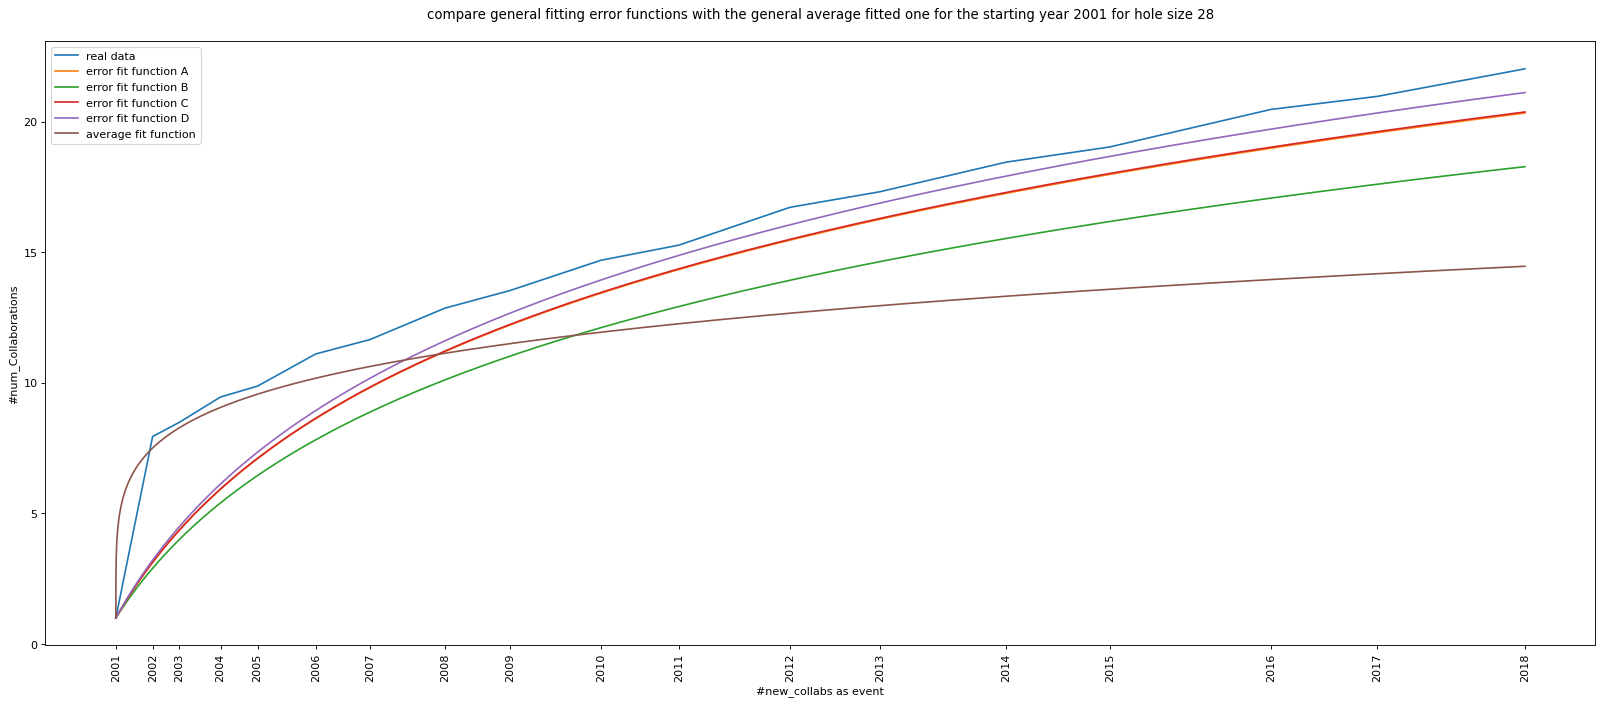

In [16]:
plot_all("2001")

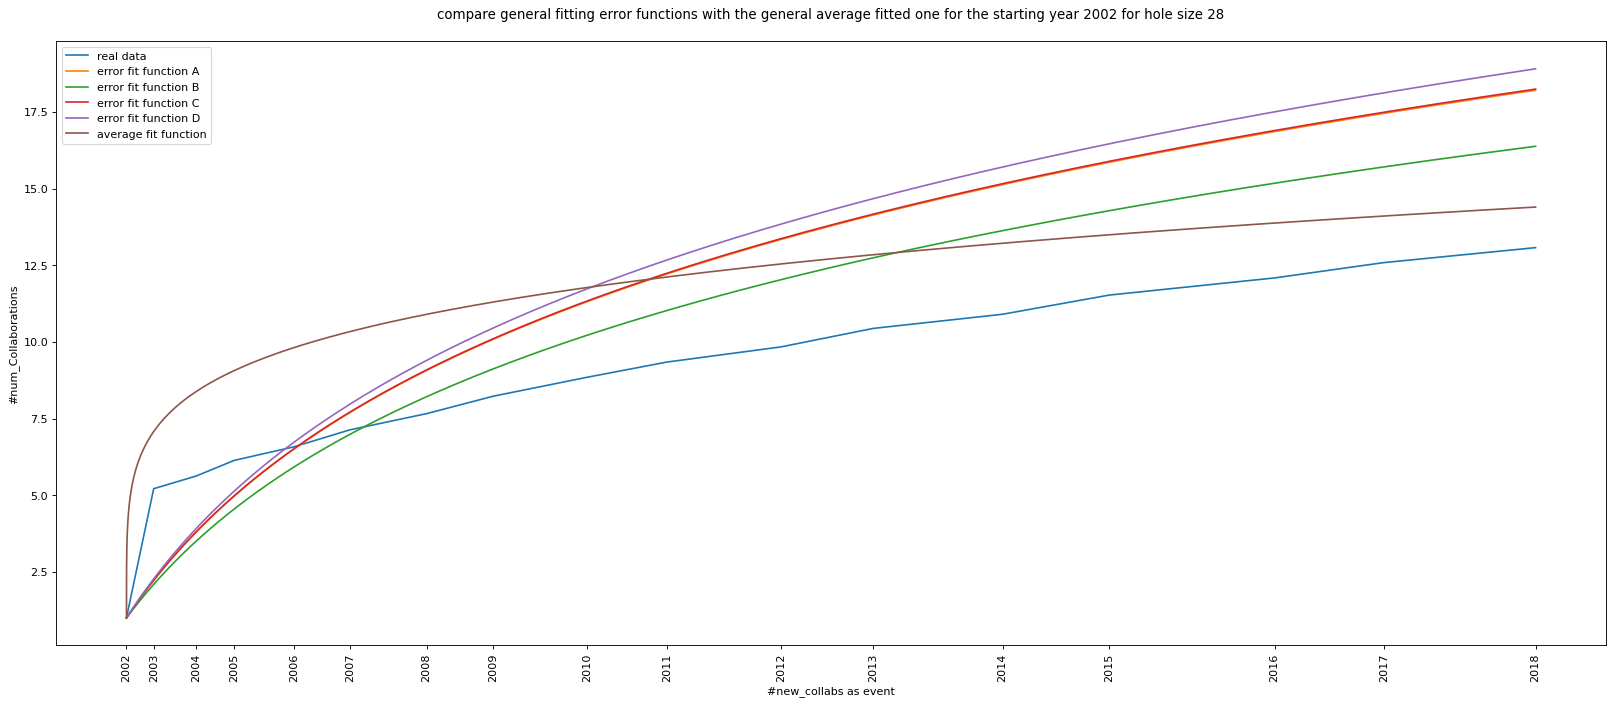

In [17]:
plot_all("2002")

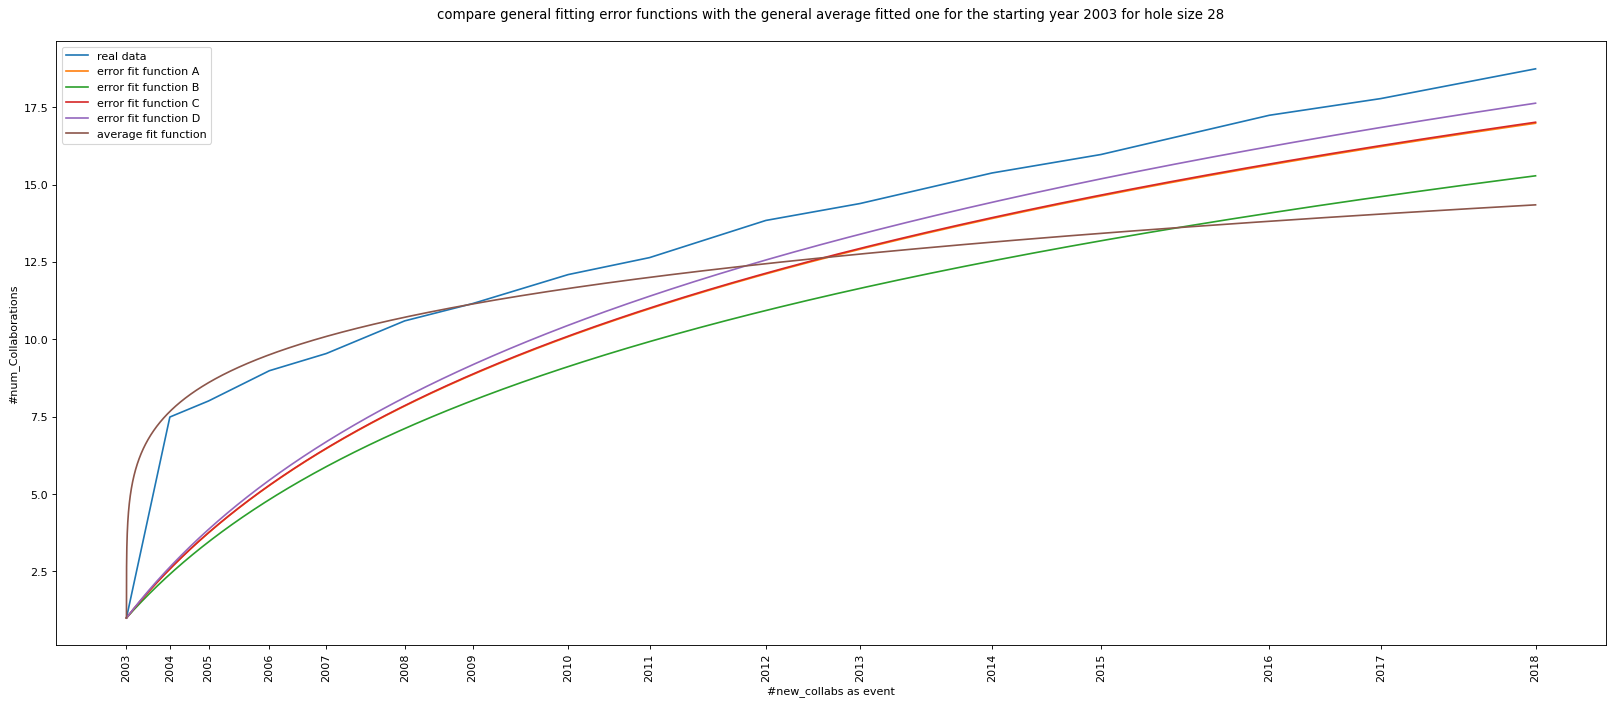

In [18]:
plot_all("2003")

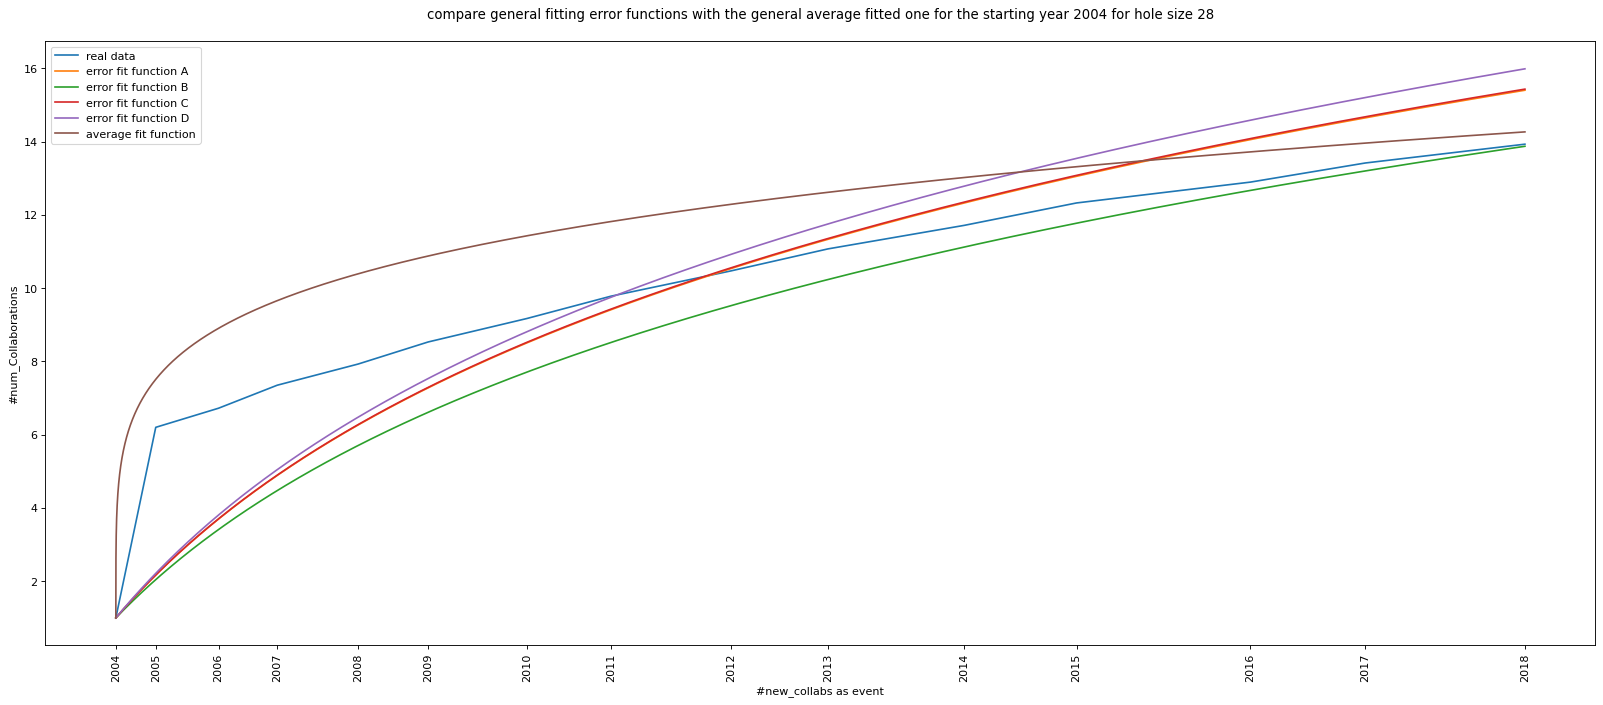

In [19]:
plot_all("2004")

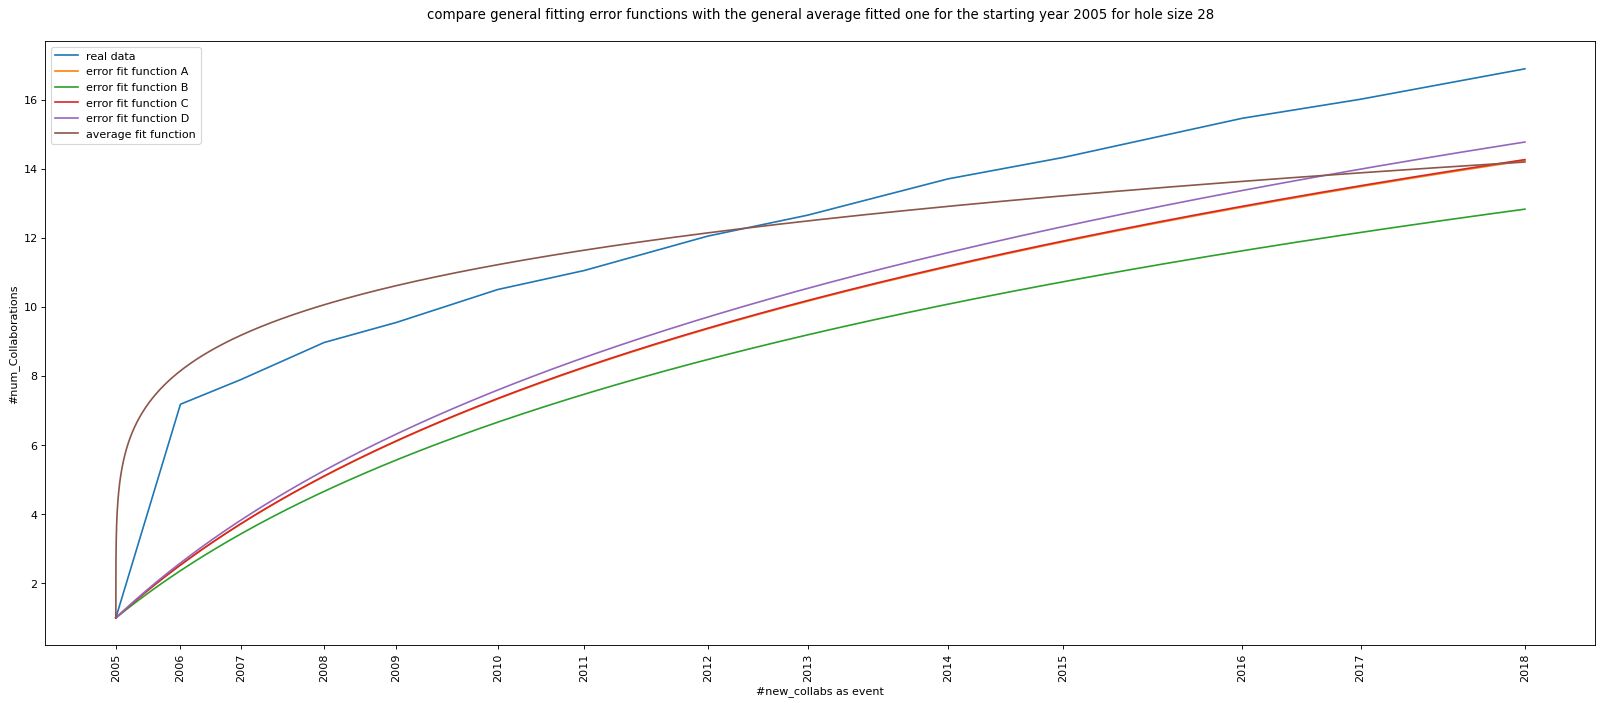

In [20]:
plot_all("2005")

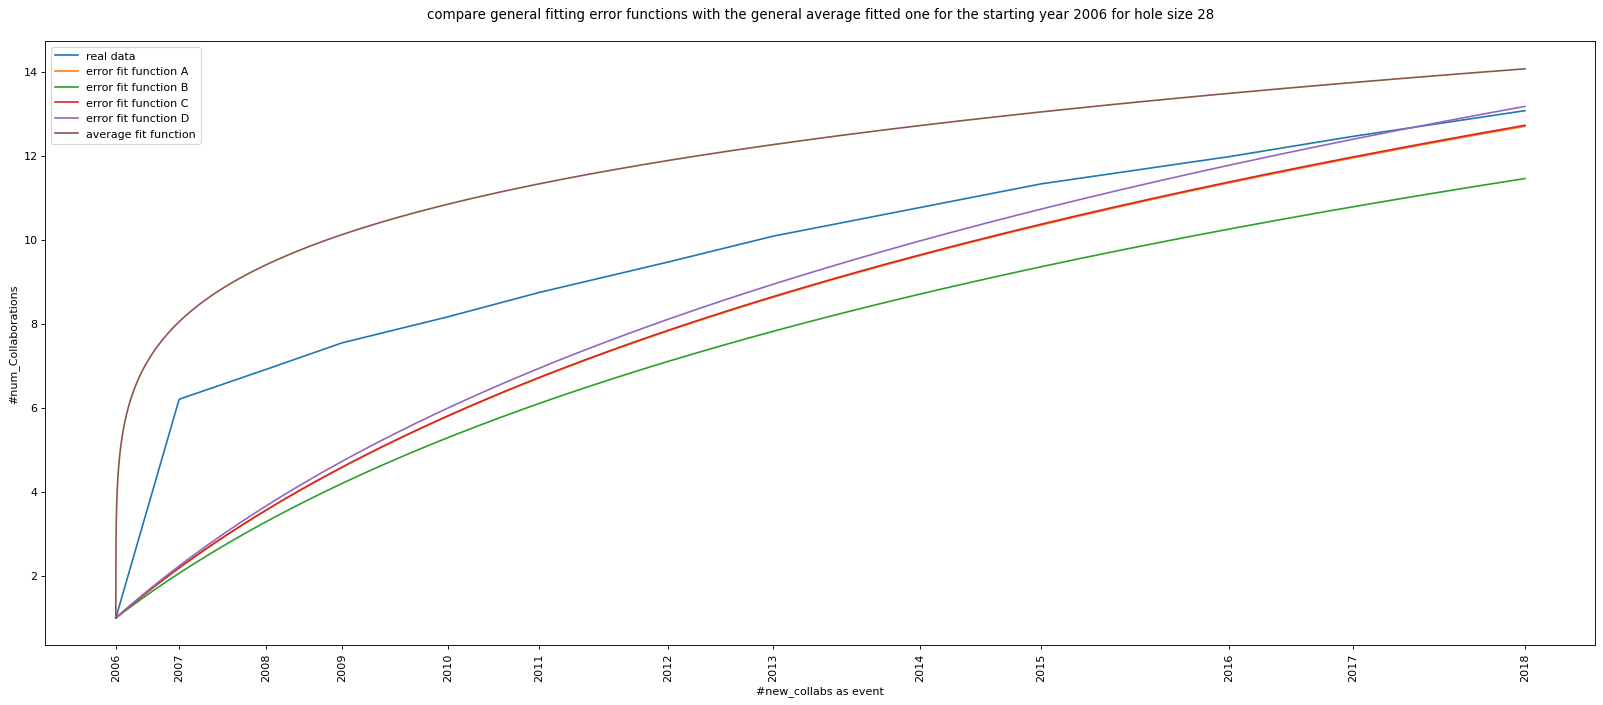

In [21]:
plot_all("2006")

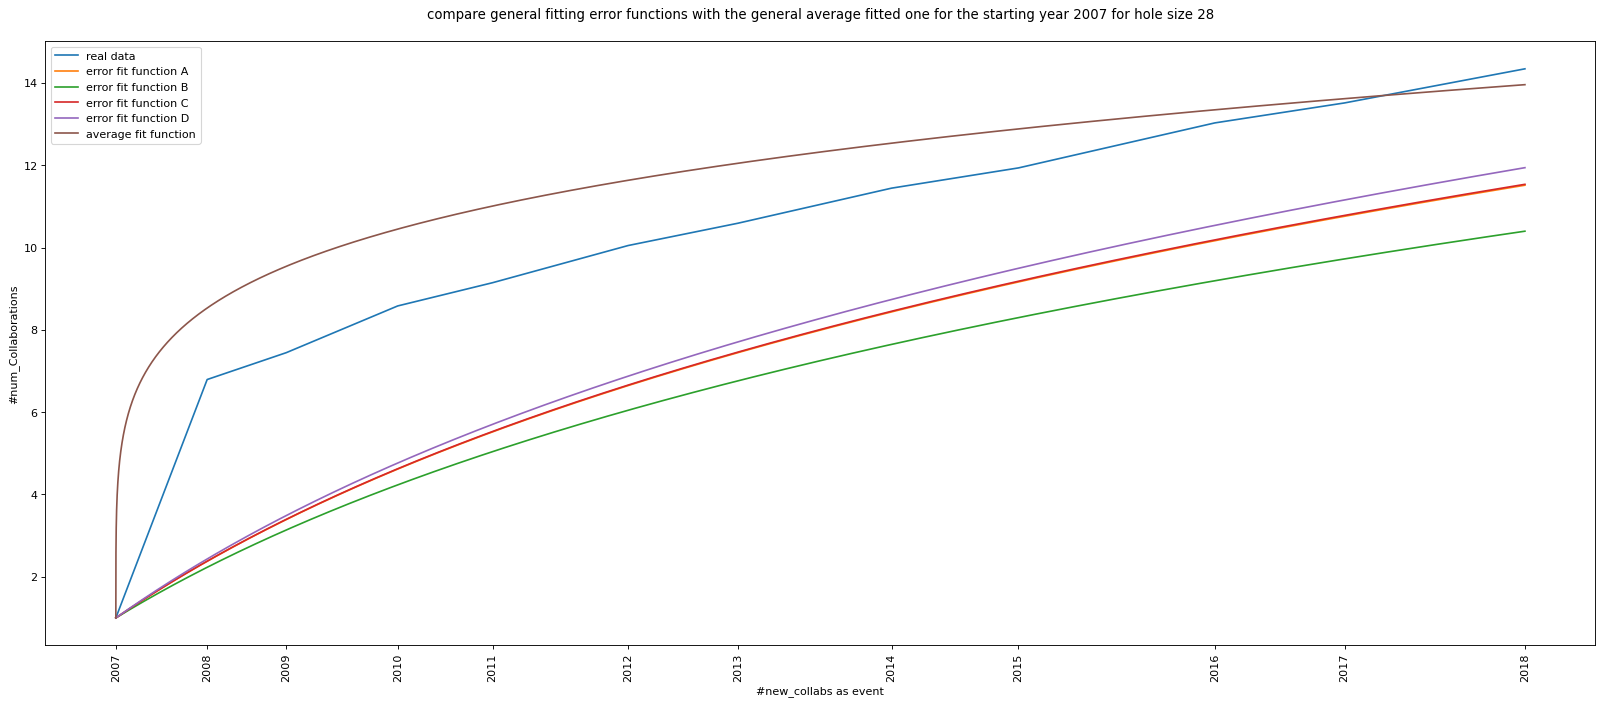

In [22]:
plot_all("2007")

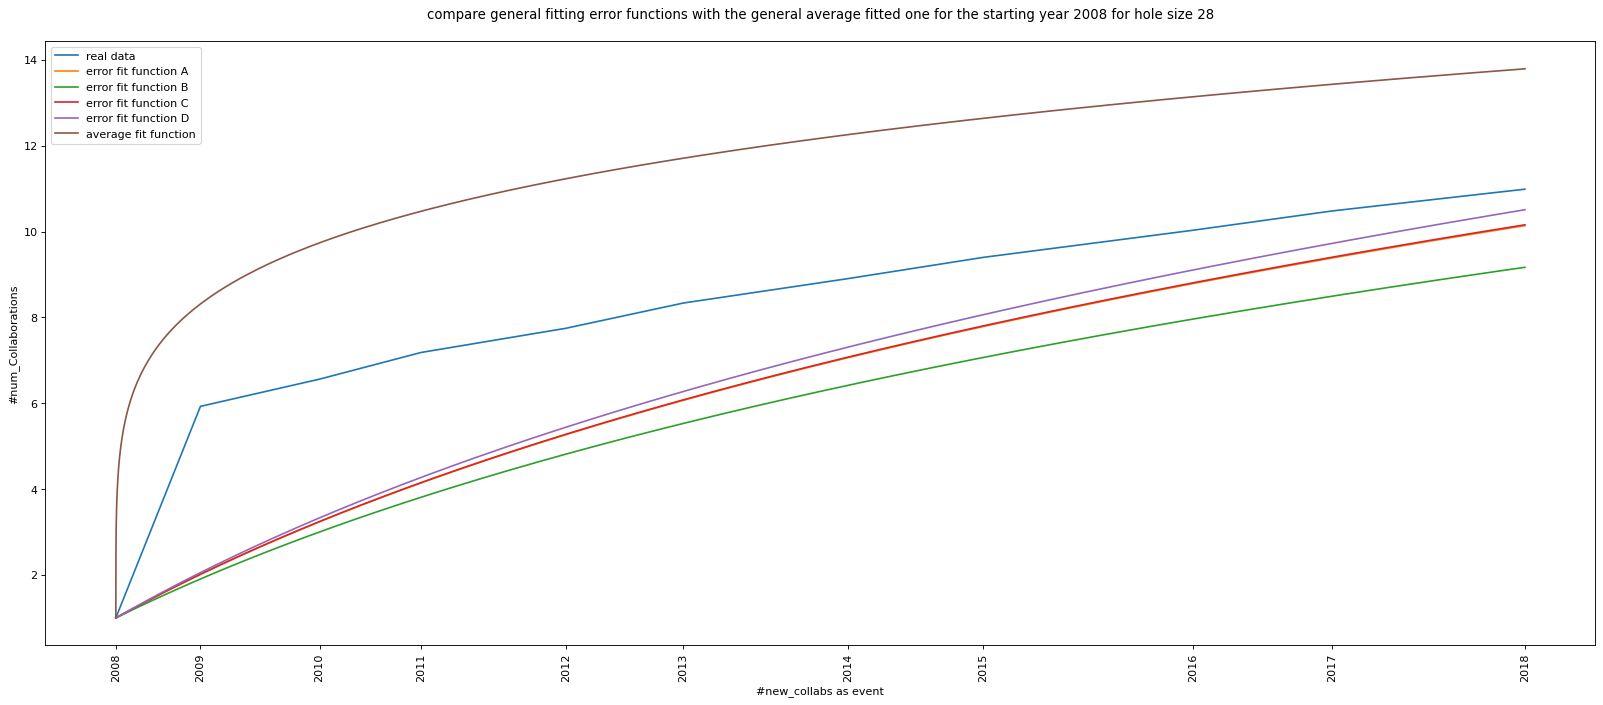

In [23]:
plot_all("2008")

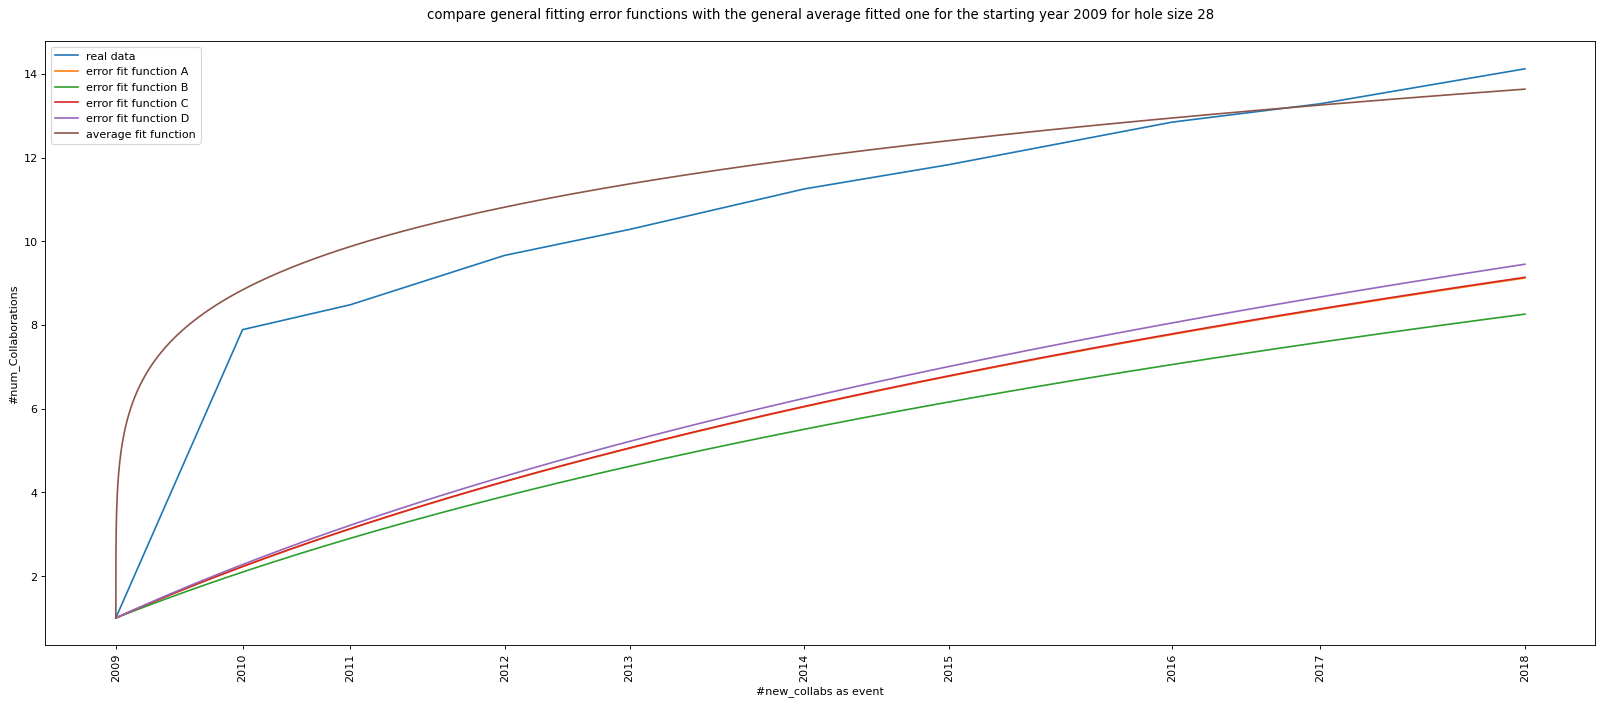

In [24]:
plot_all("2009")

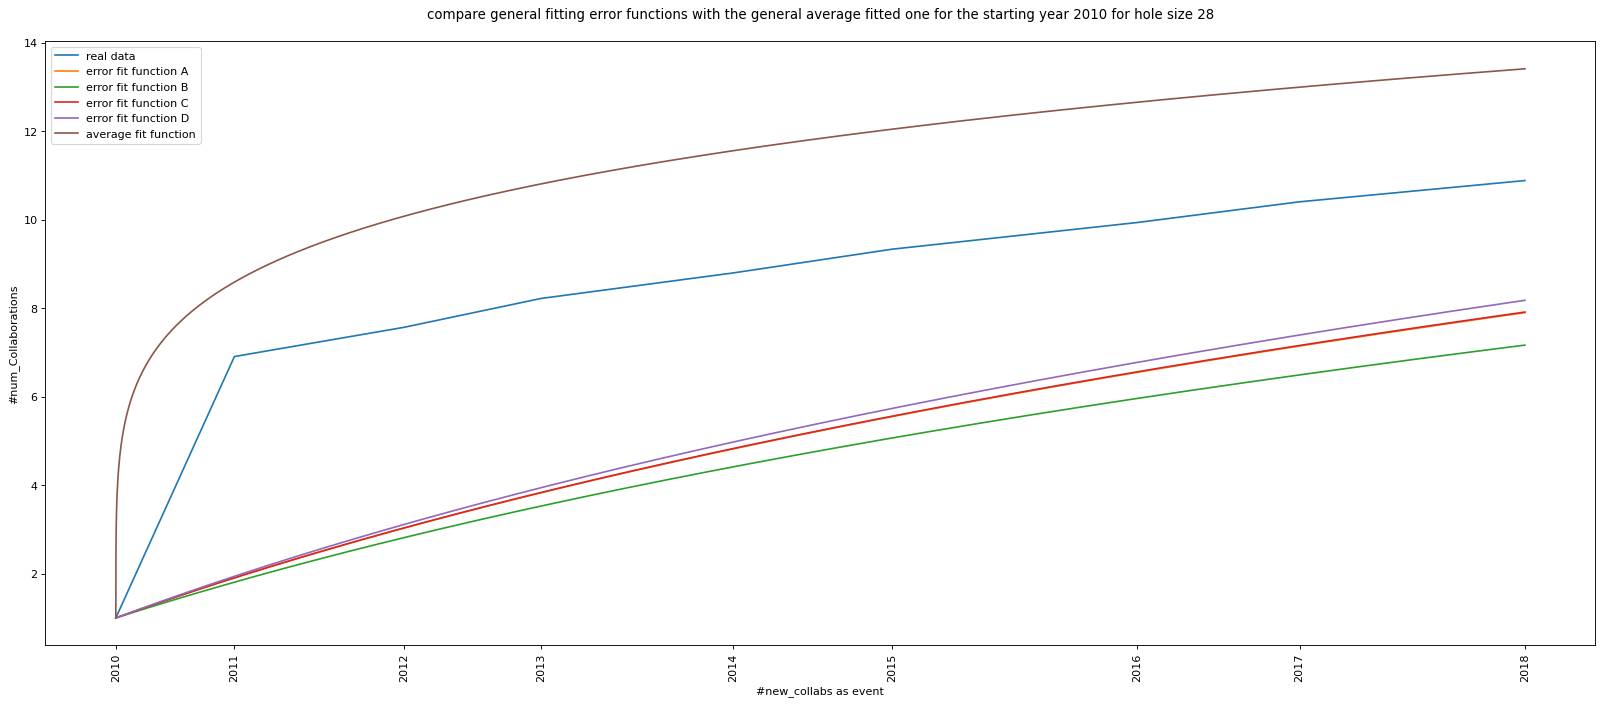

In [25]:
plot_all("2010")